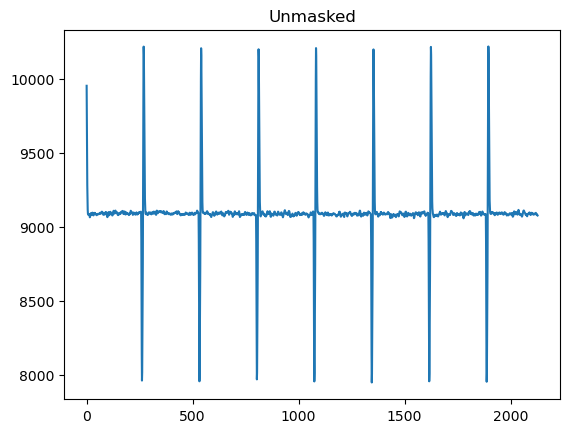

Time Elapsed for New Method: 0.0008051395416259766


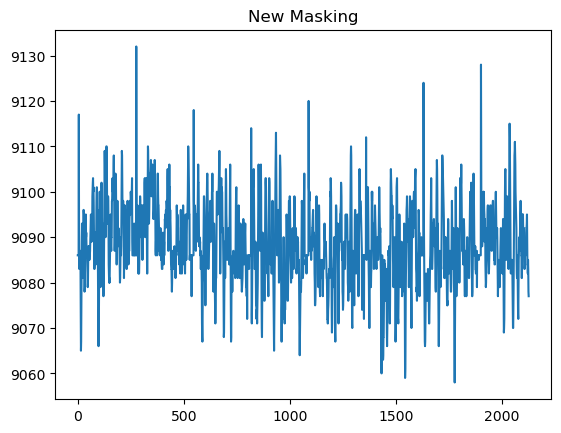

Time Elapsed for Old Method: 0.0022530555725097656


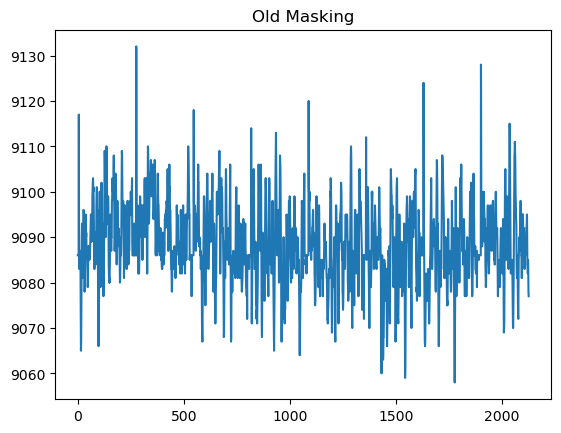

In [15]:
import uproot
import awkward as ak
import numpy as np
from myprocessor import myprocessor as myp
import time
import scipy as scipy
import matplotlib.pyplot as plt

with open('/dune/data/users/mking/ICEBERG_Run5_Decoded/filelist.txt') as f:
    filenames = f.readlines()
with open('/dune/data2/users/mking/ICEBERG_Run5_Decoded/filelist.txt') as g:
    secondfiles = g.readlines()
for i in range(len(secondfiles)):
    filenames.append(secondfiles[i])
    
infile_name = '/dune/data/users/mking/ICEBERG_Run5_Decoded/iceberg_r009055_sr01_20210324T180612_1_dl1_decode.root'
#filenames[1]
numtpcs = 2
numplanes = 3
numchannels = 1024
maxwires = 240
minwvfm = 2128
ASDlength = 1065 #the length of the ASD of the minwvfm
SampleSpacing = 0.5e-6 #0.5 microseconds per tick
infile = uproot.open(infile_name)
printname = infile_name[44:60]
events = infile['Events']
        
fADC = events['raw::RawDigits_tpcrawdecoder_daq_RunIcebergRawDecoder./raw::RawDigits_tpcrawdecoder_daq_RunIcebergRawDecoder.obj/raw::RawDigits_tpcrawdecoder_daq_RunIcebergRawDecoder.obj.fADC']
fChannel = events['raw::RawDigits_tpcrawdecoder_daq_RunIcebergRawDecoder./raw::RawDigits_tpcrawdecoder_daq_RunIcebergRawDecoder.obj/raw::RawDigits_tpcrawdecoder_daq_RunIcebergRawDecoder.obj.fChannel']

ADCarr = fADC.array(library = "ak")
Channelarr = fChannel.array(library = "ak")

counter = []
for index in range(len(ADCarr)):
    if(ak.count(ADCarr[index]) >= numchannels*(minwvfm/2)):
        counter.append(index)

for nEvent in range(1):
    for nChannel in range(1):
        index=counter[nEvent]
        CurrentWVFM = ak.to_numpy(ADCarr[index][nChannel])
        CurrentWVFM = CurrentWVFM[0:2128]
        plt.figure()
        plt.plot(CurrentWVFM)
        plt.title("Unmasked")
        plt.show()

        starttime = time.time()
        noisestd, noisemean = myp.recursive_stats(CurrentWVFM)
        peaks = np.where(abs(CurrentWVFM-noisemean)>6*noisestd)[0]
        for wvfmindex in peaks:
            i = wvfmindex
            while((abs(CurrentWVFM[i]-noisemean)>2*noisestd)&(i>=0)):
                CurrentWVFM[i] = noisemean
                i-=1
            i=wvfmindex
            while((abs(CurrentWVFM[i]-noisemean)>2*noisestd)&(i<2128)):
                CurrentWVFM[i] = noisemean
                i+=1
        endtime=time.time()
        
        plt.figure()
        print("Time Elapsed for New Method: " + str(endtime-starttime))
        plt.plot(CurrentWVFM)
        plt.title("New Masking")
        plt.show()

        plt.figure()
        CompareWVFM = ak.to_numpy(ADCarr[index][nChannel])
        CompareWVFM = CompareWVFM[0:2128]
        starttime = time.time()
        CompareWVFM = myp.mask_single_wvfm(CompareWVFM)
        endtime = time.time()
        print("Time Elapsed for Old Method: " + str(endtime-starttime))
        plt.plot(myp.mask_single_wvfm(CompareWVFM))
        plt.title("Old Masking")
        plt.show()